In [ ]:
# results obtained from E1
degree = 3
compression_rate = 0.3

In [ ]:
%%time
from utils.data import load_ucr_data_short, load_ucr_dataset, load_ucr_data_short_and_medium
# load data
data = load_ucr_data_short_and_medium()
print("number of time series:", len(data.index))

In [ ]:
from utils.plot import add_fitted_curve_to_plot


def fit_spline(method: str, ts: [(float, float)], knots: [float], num_coeffs: int, num_outliers_removed: int,
               degree=None, plot=False, axis=None):
    match method:
        case 'PAA':
            color = 'tab:gray'
            degree = 0
            _, result = fit_max_spline(ts, knots, degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'PLA':
            color = 'tab:olive'
            degree = 1
            _, result = fit_max_spline(ts, knots, degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'L8':
            color = 'tab:pink'
            if degree is None:
                degree = 3

            _, result = fit_max_spline(ts, knots, degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'L8 and L1':
            color = 'tab:blue'
            if degree is None:
                degree = 3

            eps = 2e-7
            _, result = fit_max_l1_spline(ts, knots, degree, eps=eps)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'DFT':
            color = 'tab:green'
            result = fit_DFT(ts, num_coeffs)
            fitted_curve = calculate_inverse_DFT(len(ts), num_coeffs, result)

        case 'LSQ':
            color = 'tab:purple'
            if degree is None:
                degree = 3

            if num_outliers_removed > 0:
                num_xs = len(ts) + num_outliers_removed

                num_coeffs = generate_coeff_counts(num_xs, degree, [compression_rate])[0]
                knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)

                # Alternative 1 num_coeff Ausreißer (s.u.)
                """knots = generate_knot_vector_from_coeff_count(degree=degree,
                                                              num_coeffs=num_coeffs + num_outliers_removed)"""

                # Alternative 2 (einfach neue Berechnung weglassen)
                
                xs = np.linspace(0, 1, num=num_xs)
                ts = replace_outliers(ts_without_outliers=ts, original_xs=xs)

            result = fit_LSQ_spline(time_series=ts, knots=knots, degree=degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

    # TODO Unterschied zwischen L8 und L8-L1 doch wieder zu groß? Hat doch eigentlich gepasst?
    max_dist = np.max(np.abs(np.array(fitted_curve) - np.array([x[1] for x in ts])))
    mse = mean_squared_error(fitted_curve, [x[1] for x in ts])
    mae = mean_absolute_error(fitted_curve, [x[1] for x in ts])

    """if plot & (axis is not None):
        add_fitted_curve_to_plot(axis, fitted_curve, max_dist, color=color, label=method)"""

    if plot:
        if axis is not None:
            add_fitted_curve_to_plot(axis, fitted_curve, max_dist, color=color, label=method)
        else:
            add_fitted_curve_to_plot(plt, fitted_curve, max_dist, color=color, label=method)

    return {'max_dist': max_dist,
            'MSE': mse,
            'MAE': mae}


In [ ]:
from tsfel import mean_diff
from utils.data import remove_outliers, replace_outliers
from utils.spline import generate_coeff_counts, generate_knot_vector_from_coeff_count
from utils.fit import fit_max_spline, fit_max_l1_spline, fit_DFT, calculate_inverse_DFT, fit_LSQ_spline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.spline import evaluate_spline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

results = []
num_rows = len(data.index)
ts_properties = []

for idx, row in data.iterrows():
    original_time_series = row['data']
    time_series_lof = remove_outliers(row['data'])
    n_outliers = len(original_time_series) - len(time_series_lof)
    print(f"{row['dataset']} no. {row['num']}, {round(idx / num_rows * 100, 1)}% processed")

    f, axes = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(12)

    axes[0].set_title("Data including outliers")
    axes[1].set_title("Data without outliers")

    for ts, num_outliers_removed in [(original_time_series, -1), (time_series_lof, n_outliers)]:
        #for ts in [original_time_series, time_series_lof]:
        #num_outliers_removed = len(original_time_series) - len(ts)
        #assert num_outliers_removed >= 0
        print("len(ts):", len(ts))

        if num_outliers_removed == 0:
            continue

        ts_properties.append({
            'dataset': row['dataset'],
            'num': row['num'],
            'num_data_pts': len(ts),
            'num_outliers_removed': num_outliers_removed if num_outliers_removed >= 0 else 0,
            'mean_diff': mean_diff(ts),
            'max_fst_derivative': max(pd.Series([tup[0] for tup in ts]).diff().dropna()),
            'max_snd_derivative': max(pd.Series([tup[0] for tup in ts]).diff().diff().dropna())
        })

        # Alternative 1 zur Berechnung der Koeffizienten bei TS ohne Ausreißer
        """num_coeffs = generate_coeff_counts(len(original_time_series), degree, compression_ratios=[compression_rate])[0]
        knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=(num_coeffs - num_outliers_removed))"""

        # Alternative 2 zur Berechnung der Koeffizienten bei TS ohne Ausreißer
        """num_coeffs = generate_coeff_counts(len(original_time_series), degree, compression_ratios=[compression_rate])[0]
        knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)"""

        # ursprüngliche Variante (es müssen compr_rate * n_outliers viele Punkte zusätlich gespeichert werden)
        num_coeffs = generate_coeff_counts(len(ts), degree, compression_ratios=[compression_rate])[0]
        knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)

        #fig,ax = plt.subplots()

        for method in ['L8', 'L8 and L1', 'LSQ', 'PAA', 'PLA', 'DFT']:
            #metrics = fit_spline(method, ts, knots, num_coeffs, num_outliers_removed)

            plot_method = False

            if method in ['L8', 'LSQ', 'L8 and L1']:
                plot_method = True

            if num_outliers_removed > 0:
                axis = axes[1]
            else:
                axis = axes[0]

            metrics = fit_spline(method, ts, knots, num_coeffs, num_outliers_removed, plot=plot_method, axis=axis)

            results.append({
                'dataset': row['dataset'],
                'num': row['num'],
                #'num_data_pts': len(ts),
                #'num_outliers_removed': num_outliers_removed if num_outliers_removed >= 0 else 0,
                'num_coeffs': num_coeffs,
                'method': method,
                'max_dist': metrics['max_dist'],
                'MSE': metrics['MSE'],
                'MAE': metrics['MAE'],
                #'mean_diff': mean_diff(ts),
                #'fst_derivative': pd.Series([tup[0] for tup in ts]).diff().dropna(),
                #'snd_derivative':pd.Series([tup[0] for tup in ts]).diff().diff().dropna()
            })

        #ax.legend()
        #ax.set_xlabel('X-axis')
        #ax.set_ylabel('Y-axis')
        #ax.set_title('Multiple Plots on the Same Figure')

        axis.scatter([d[0] for d in ts], [d[1] for d in ts], color="brown", marker='.')

        #for knot in knots:
        #axis.axvline(x=knot, linestyle='dotted')

        print("without outliers: len(ts):", len(ts), "len(knots)", len(knots))

    plt.subplots_adjust(bottom=0.25, top=0.95)
    axes[0].legend(loc='upper right')
    axes[1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
pd.set_option('display.float_format', '{:.8f}'.format)

e2_results = pd.DataFrame(results).drop_duplicates()
mean_values = e2_results.groupby('method').agg({'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values

In [ ]:
"""
import pandas as pd
pd.set_option('display.float_format', '{:.8f}'.format)

# Calculate mean values for each accuracy measure separately
mean_max_dist = e2_results.groupby('method')['max_dist'].mean().reset_index()
mean_mse = e2_results.groupby('method')['MSE'].mean().reset_index()
mean_mae = e2_results.groupby('method')['MAE'].mean().reset_index()

# Merge the mean values into a single DataFrame
mean_values = mean_max_dist.merge(mean_mse, on='method').merge(mean_mae, on='method')
mean_values"""

In [ ]:
# combine results df with ts properties df for analysis later
ts_props = pd.DataFrame(ts_properties).drop_duplicates()
e2 = pd.merge(e2_results, ts_props, how='left', on=['dataset','num'])
e2

In [13]:
df_no_outliers = e2[e2['num_outliers_removed'] > 0]
df_with_outliers = e2[e2['num_outliers_removed'] == 0]
#df_no_outliers = e2_results[e2_results['num_outliers_removed'] > 0]
#df_with_outliers = e2_results[e2_results['num_outliers_removed'] == 0]

mean_values_no_outliers = df_no_outliers.groupby('method').agg(
    {'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values_no_outliers.rename(columns={'max_dist': 'max_dist w/o o.', 'MSE': 'MSE w/o o.', 'MAE': 'MAE w/o o.'},
                               inplace=True)

mean_values_with_outliers = df_with_outliers.groupby('method').agg(
    {'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values_with_outliers.rename(columns={'max_dist': 'max_dist', 'MSE': 'MSE', 'MAE': 'MAE'}, inplace=True)

mean_values_combined = pd.merge(mean_values_with_outliers, mean_values_no_outliers, on='method', how='outer')
mean_values_combined

,method,max_dist,MSE,MAE,max_dist w/o o.,MSE w/o o.,MAE w/o o.
0,DFT,0.673011,0.013758,0.056821,0.696348,0.014341,0.058671
1,L8,0.042733,0.001919,0.029264,0.043156,0.001977,0.029603
2,L8 and L1,0.042903,0.001038,0.015088,0.043342,0.001070,0.015145
3,LSQ,0.119827,0.001021,0.012987,0.122864,0.001058,0.013122
4,PAA,0.184403,0.031773,0.149617,0.182673,0.031813,0.149288
5,PLA,0.047779,0.002851,0.036085,0.048347,0.002946,0.036631


In [17]:
import pandas as pd
import statsmodels.api as sm

# Correlation Analysis
correlation_matrix = e2[['max_dist', 'MSE', 'MAE', 'num_data_pts', 'mean_diff', 'max_fst_derivative', 'max_snd_derivative']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Regression Analysis
X = e2[['num_data_pts', 'mean_diff', 'max_fst_derivative', 'max_snd_derivative']]
y = e2['max_dist']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


Correlation Matrix:
                    max_dist       MSE       MAE  num_data_pts  mean_diff  \
max_dist            1.000000  0.407711  0.328233     -0.072239   0.018828   
MSE                 0.407711  1.000000  0.926965     -0.105025   0.018706   
MAE                 0.328233  0.926965  1.000000     -0.097919   0.023588   
num_data_pts       -0.072239 -0.105025 -0.097919      1.000000   0.144304   
mean_diff           0.018828  0.018706  0.023588      0.144304   1.000000   
max_fst_derivative  0.031324 -0.018647 -0.033002     -0.314438  -0.298556   
max_snd_derivative  0.030580 -0.026090 -0.040922     -0.262780  -0.292322   

                    max_fst_derivative  max_snd_derivative  
max_dist                      0.031324            0.030580  
MSE                          -0.018647           -0.026090  
MAE                          -0.033002           -0.040922  
num_data_pts                 -0.314438           -0.262780  
mean_diff                    -0.298556           -0.292322

In [31]:
import pandas as pd
import statsmodels.api as sm

# Load your dataframe
# Assuming your dataframe is named 'df'

# Filter relevant columns
data = e2[['mean_diff', 'max_dist', 'method']]

# Create dummy variables for the 'method' column
data = pd.get_dummies(data, columns=['method'], drop_first=True)

# Separate independent (X) and dependent (y) variables
X = data.drop(columns=['max_dist'])
y = data['max_dist']

# Add constant for intercept term
X = sm.add_constant(X)

# Fit the regression model for each method
results = {}
method_columns = data.iloc[:, 2:]
for method_col in method_columns:
    method_name = method_col.replace('method_', '')
    method_data = data[[method_col] + ['mean_diff']]

    model = sm.OLS(y, method_data.astype(float)).fit()
    results[method_name] = model.summary()

# Print results
for method, result in results.items():
    print(f"Method: {method}")
    print(result)
    print("\n")


Method: L8
                                 OLS Regression Results                                
Dep. Variable:               max_dist   R-squared (uncentered):                   0.337
Model:                            OLS   Adj. R-squared (uncentered):              0.334
Method:                 Least Squares   F-statistic:                              140.1
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                    6.24e-50
Time:                        20:05:45   Log-Likelihood:                         -73.432
No. Observations:                 554   AIC:                                      150.9
Df Residuals:                     552   BIC:                                      159.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [33]:
import pandas as pd
import statsmodels.api as sm

# Load your dataframe
# Assuming your dataframe is named 'df'

# Convert 'mean_diff' column to numeric (if not already)
e2['mean_diff'] = pd.to_numeric(e2['mean_diff'], errors='coerce')

# Drop rows with NaN values in 'mean_diff' column
df = e2.dropna(subset=['mean_diff'])

# Filter relevant columns
data = df[['mean_diff', 'max_dist', 'num_outliers_removed', 'method']]

# Create dummy variables for the 'method' column
data = pd.get_dummies(data, columns=['method'], drop_first=True)

# Separate data for num_outliers > 0 and num_outliers == 0
data_with_outliers = data[data['num_outliers_removed'] > 0]
data_without_outliers = data[data['num_outliers_removed'] == 0]

# Separate independent (X) and dependent (y) variables for each case
X_with_outliers = data_with_outliers.drop(columns=['max_dist', 'num_outliers_removed'])
y_with_outliers = data_with_outliers['max_dist']

X_without_outliers = data_without_outliers.drop(columns=['max_dist', 'num_outliers_removed'])
y_without_outliers = data_without_outliers['max_dist']

# Add constant for intercept term
X_with_outliers = sm.add_constant(X_with_outliers)
X_without_outliers = sm.add_constant(X_without_outliers)

# Fit the regression model for each case
model_with_outliers = sm.OLS(y_with_outliers, X_with_outliers.astype(float)).fit()
model_without_outliers = sm.OLS(y_without_outliers, X_without_outliers.astype(float)).fit()

# Print results
print("Results for num_outliers > 0:")
print(model_with_outliers.summary())

print("\nResults for num_outliers == 0:")
print(model_without_outliers.summary())


Results for num_outliers > 0:
                            OLS Regression Results                            
Dep. Variable:               max_dist   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     85.87
Date:                Sat, 10 Feb 2024   Prob (F-statistic):           3.53e-59
Time:                        20:07:53   Log-Likelihood:                 101.64
No. Observations:                 271   AIC:                            -189.3
Df Residuals:                     264   BIC:                            -164.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

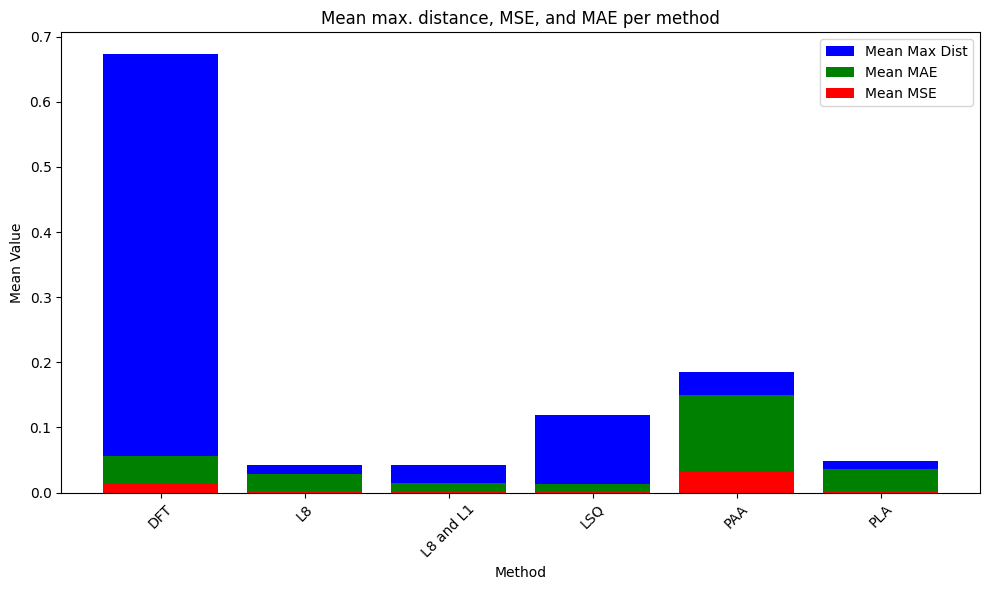

In [14]:
import matplotlib.pyplot as plt

# Plot mean values
plt.figure(figsize=(10, 6))

plt.bar(mean_values['method'], mean_values['max_dist'], color='b', label='Mean Max Dist')
plt.bar(mean_values['method'], mean_values['MAE'], color='g', label='Mean MAE')
plt.bar(mean_values['method'], mean_values['MSE'], color='r', label='Mean MSE')
plt.xlabel('Method')
plt.ylabel('Mean Value')
plt.title('Mean max. distance, MSE, and MAE per method')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
